**Adaptive Cruise Control (ACC)**

Learn from https://github.com/iinc/acc

Using camera to collect data and a prediction model to return the speed of the vehicle based on the distance to the vehicle ahead.

The model includes image preprocessing (grey scale, reduce noise, edge detection, crop), detect the empty portion of the lane, use this portion to decide the speed.

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import sys
import numpy as np
import math

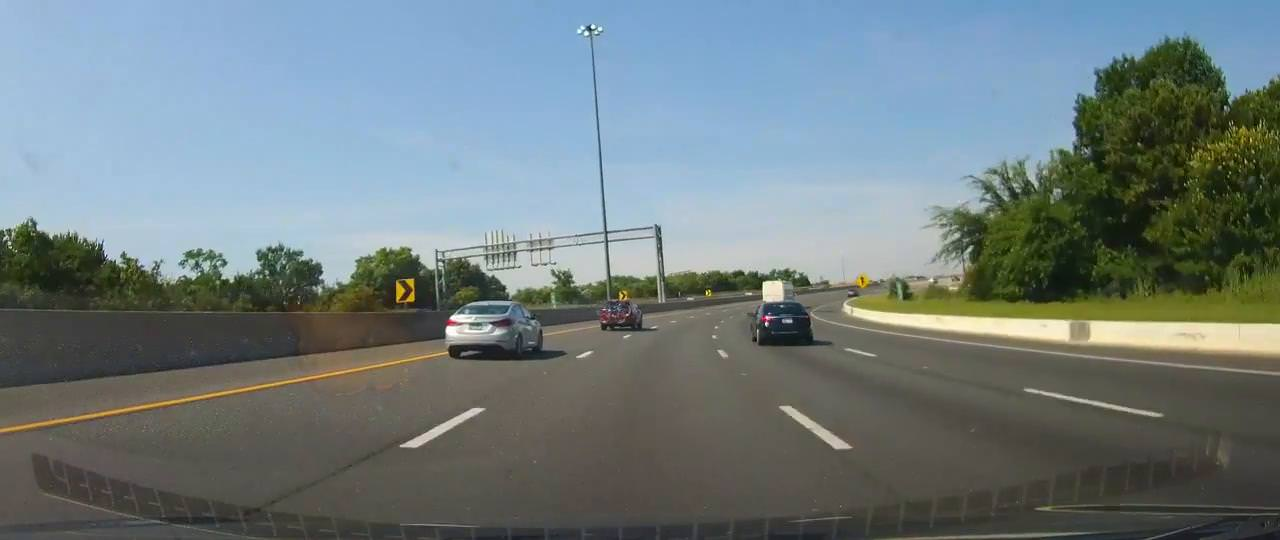

In [ ]:
img = cv2.imread(cv2.samples.findFile("raw_pixel.jpeg"))
if img is None:
    sys.exit("Could not read the image.")

cv2_imshow(img)

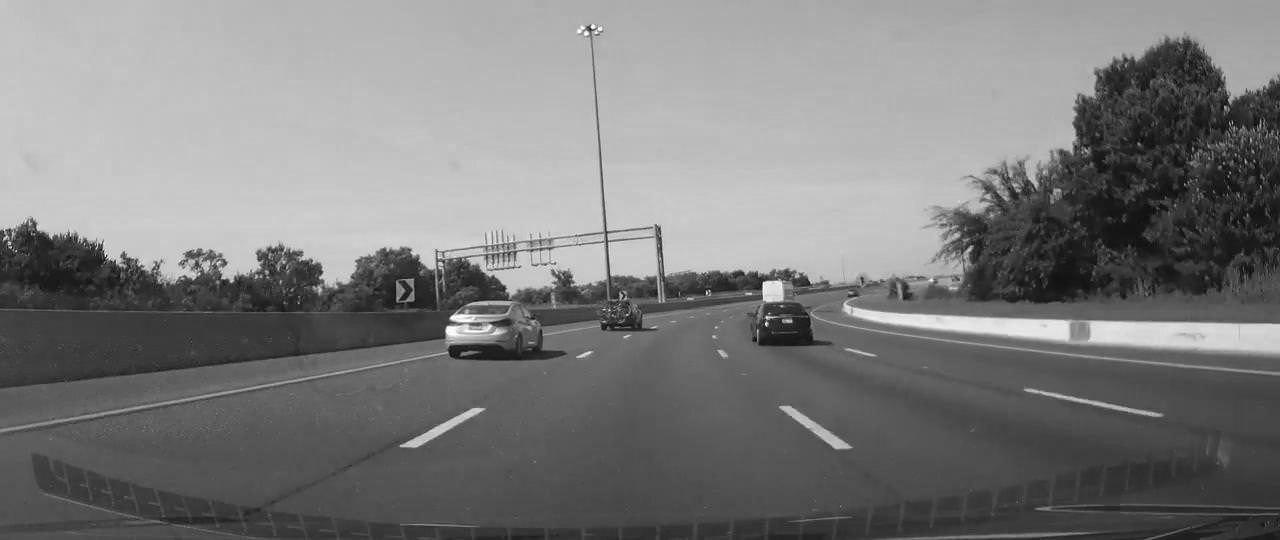

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
cv2_imshow(gray)

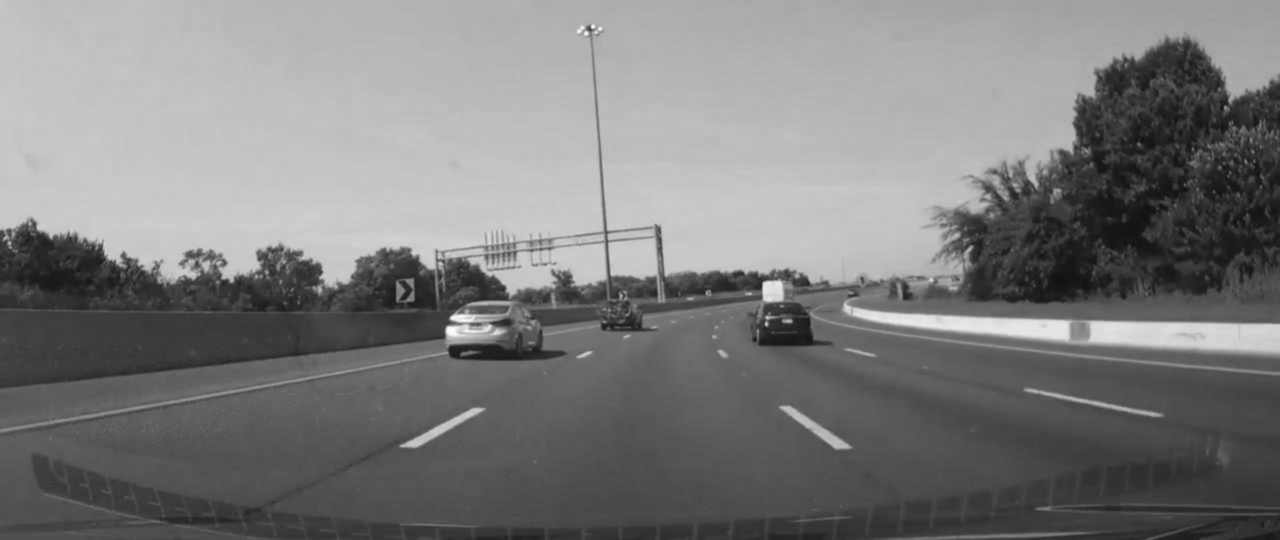

In [ ]:
blurred = cv2.GaussianBlur(gray, (3, 3), 0)
cv2_imshow(blurred)

https://docs.opencv.org/master/da/d5c/tutorial_canny_detector.html

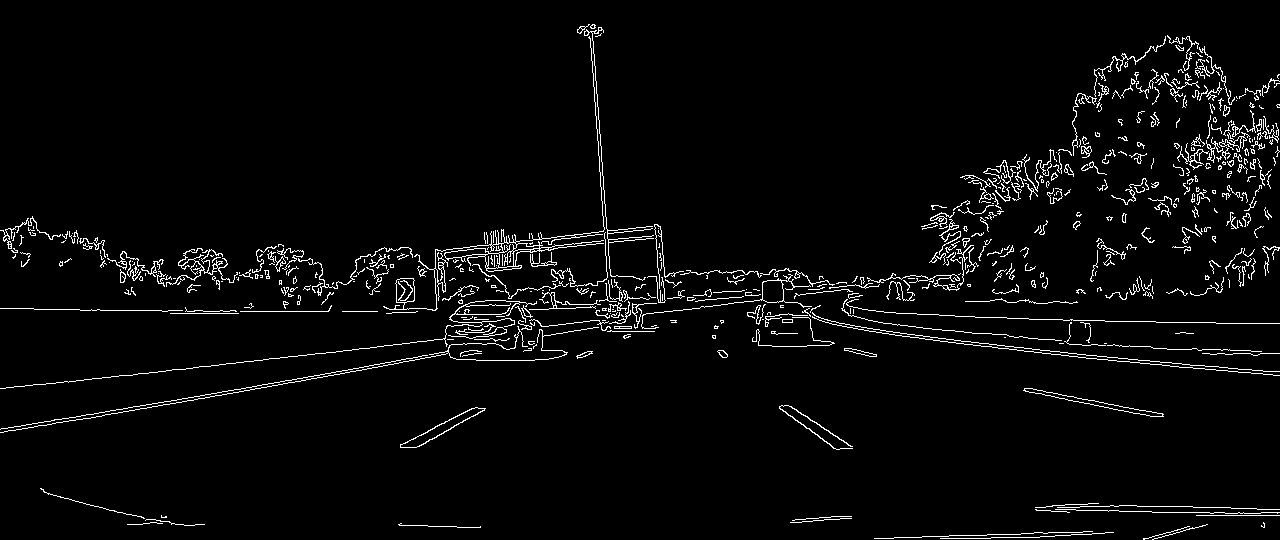

In [ ]:
high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
lowThresh = 0.5*high_thresh
edges = cv2.Canny(blurred, lowThresh, high_thresh)
cv2_imshow(edges)

1280 540


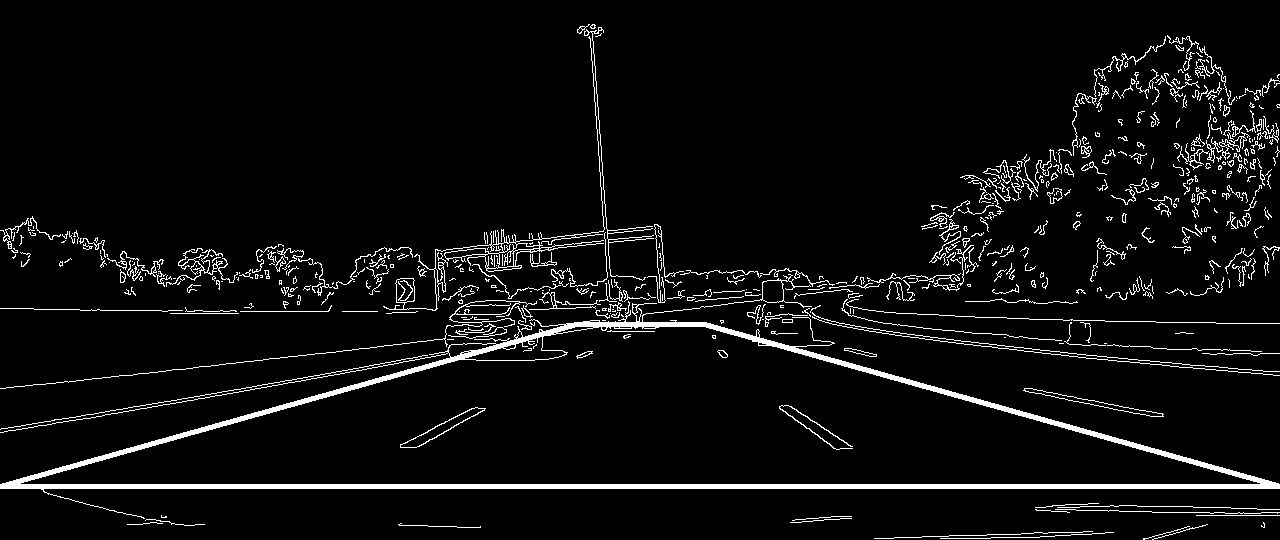

In [ ]:
print(edges.shape[1],edges.shape[0])
pts = np.array([[45/100.*edges.shape[1], 60/100.*edges.shape[0]],
                [55/100.*edges.shape[1], 60/100.*edges.shape[0]],
                [100/100.*edges.shape[1], 90/100.*edges.shape[0]],
                [0/100.*edges.shape[1], 90/100.*edges.shape[0]]], np.int32)
pts = pts.reshape((-1,1,2))
test3 = cv2.polylines(edges,[pts],True,(255,0,0),3)
cv2_imshow(test3)

width,height 1280.0 162.0


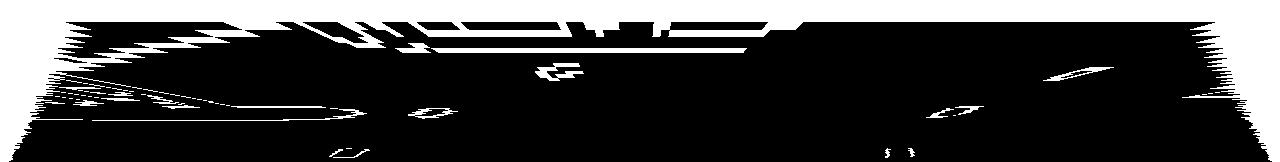

In [ ]:
warp_cache = {
    'src': None,
    'warp_matrix': None,
    'width': None,
    'height': None
}
#(tl, tr, br, bl)
src = np.array([[45/100.*edges.shape[1], 60/100.*edges.shape[0]],
                [55/100.*edges.shape[1], 60/100.*edges.shape[0]],
                [100/100.*edges.shape[1], 90/100.*edges.shape[0]],
                [0/100.*edges.shape[1], 90/100.*edges.shape[0]]], np.float32)

width =  (src[2][0] - src[3][0])
height = src[2][1] - src[1][1]

print("width,height",width, height)
dst = np.array([[0, 0],
                [width, 0],
                [width, height],
                [0, height]], np.float32)

warp_matrix = cv2.getPerspectiveTransform(src, dst)
warp_back_matrix = cv2.getPerspectiveTransform(dst, src)

warp_cache['src'] = src
warp_cache['width'] = int(width)
warp_cache['height'] = int(height)
warp_cache['source_width'] = int(edges.shape[1])
warp_cache['source_height'] = int(edges.shape[0])
warp_cache['warp_matrix'] = warp_matrix
warp_cache['warp_back_matrix'] = warp_back_matrix

warp_edges = cv2.warpPerspective(edges, warp_cache['warp_matrix'], (warp_cache['width'], warp_cache['height']), flags=cv2.INTER_LINEAR & cv2.WARP_FILL_OUTLIERS)
cv2_imshow(warp_edges)

In [ ]:
edges_img = np.zeros((edges.shape[0], edges.shape[1], 3))
edges_img[:edges_img.shape[0],:edges_img.shape[1],0] = edges

warp_edges_img = np.zeros((warp_edges.shape[0], warp_edges.shape[1], 3))
warp_edges_img[:warp_edges_img.shape[0],:warp_edges_img.shape[1],0] = warp_edges

cv2.polylines(img, np.int_([warp_cache['src']]), True, (0,255, 0))
cv2.polylines(edges_img, np.int_([warp_cache['src']]), True, (0,255, 0))

lane_width_min = 250
height = 8
width = 30

# resize the image as a quick way to condense the array into something we can work with in real time
sums = cv2.resize(warp_edges, (math.ceil(warp_edges.shape[1]/width), math.ceil(warp_edges.shape[0]/height)), interpolation=cv2.INTER_AREA)
cv2_imshow(sums)

In [ ]:
left_points = []
right_points = []
for r in range(sums.shape[0] - 2, 0, -1):
    if left_points and right_points:
        # average previous points to use a next starting point
        n = min(len(left_points), len(right_points), 3)
        c = 0
        for i in range(-1, -n-1, -1):
            c += left_points[i][1] + right_points[i][1]
        c = int(c/n/2)
    else:
        c = int(sums.shape[1]/2)

    min_c = 0
    for i in range(c-1, min_c, -1):
        count = sums[r][i] + sums[r+1][i] + sums[r][i+1] + sums[r+1][i+1]
        if count > 255/4/ 4:
            min_c = i
            break

    max_c = sums.shape[1] - 1
    for i in range(c+1, max_c, 1):
        count = 0
        count = sums[r][i] + sums[r+1][i] + sums[r][i-1] + sums[r+1][i-1]
        if count > 255/4/ 4:
            max_c = i
            break

    cv2.line(warp_edges_img, (min_c*width, int(r*height)), (max_c*width, int(r*height)), (255,255,255), 1)
  
    cv2.circle(warp_edges_img, (c*width, int(r*height)), 2, (0, 255, 0), thickness=2)

    if max_c - min_c < lane_width_min/width:
        break

    if min_c > 0:
        left_points.append((r, min_c))
    if max_c < sums.shape[1] - 1:
        right_points.append((r, max_c))


if left_points and right_points:
    min_y = min(left_points[-1][1]*height, right_points[-1][1])*height
    print(min_y)

320


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in ubyte_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: overflow encountered in ubyte_scalars
  


In [ ]:
def warp_back(warped_edges):
    return cv2.warpPerspective(warped_edges, warp_cache['warp_back_matrix'], (warp_cache['source_width'], warp_cache['source_height']), flags=cv2.INTER_LINEAR & cv2.WARP_FILL_OUTLIERS).astype(np.uint8)


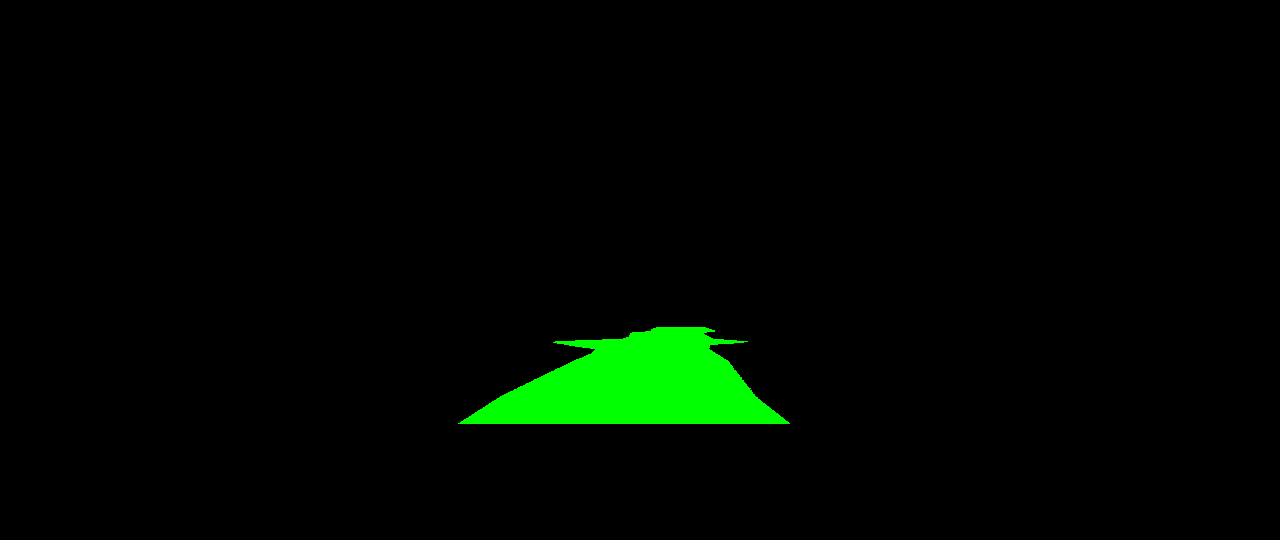

In [ ]:
warp_back_img = np.zeros_like(warp_edges_img)

if left_points and right_points:
    pts = left_points + right_points[::-1]

    for i in range(0, len(pts), 1):
        pts[i] = (pts[i][1]*width, pts[i][0]*height)

    cv2.fillPoly(warp_back_img, np.int_([pts]), (0,255, 0))
    cv2.polylines(warp_edges_img, np.int_([pts]), False, (0,255, 0))

im2 = warp_back(warp_back_img)
cv2_imshow(im2)

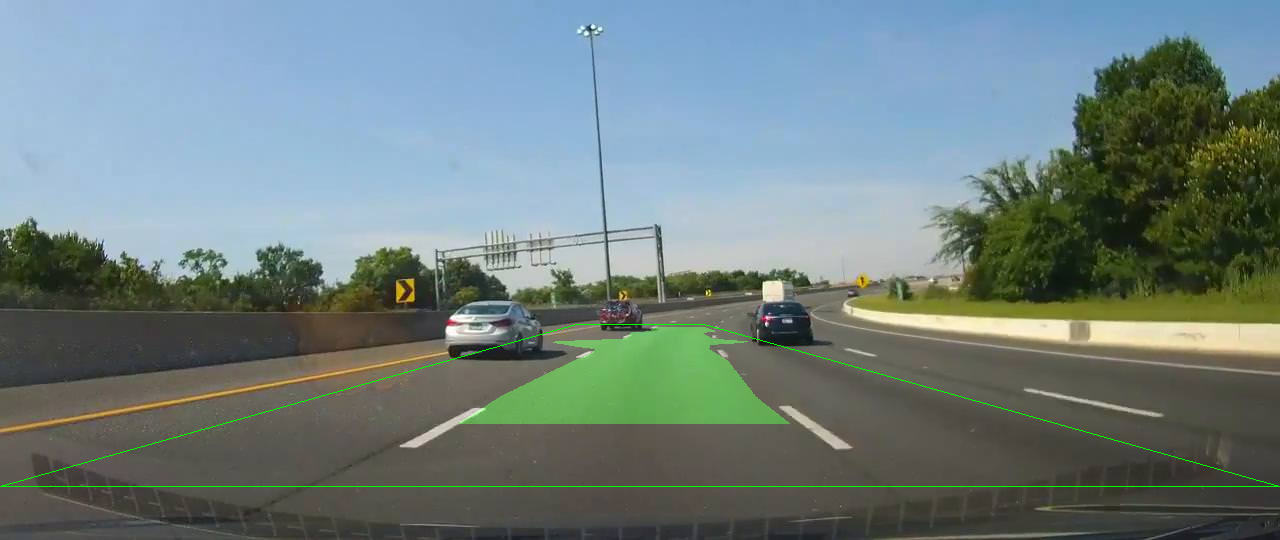

In [ ]:
result = cv2.addWeighted(img, 1, im2, 0.3, 0)
cv2_imshow(result)

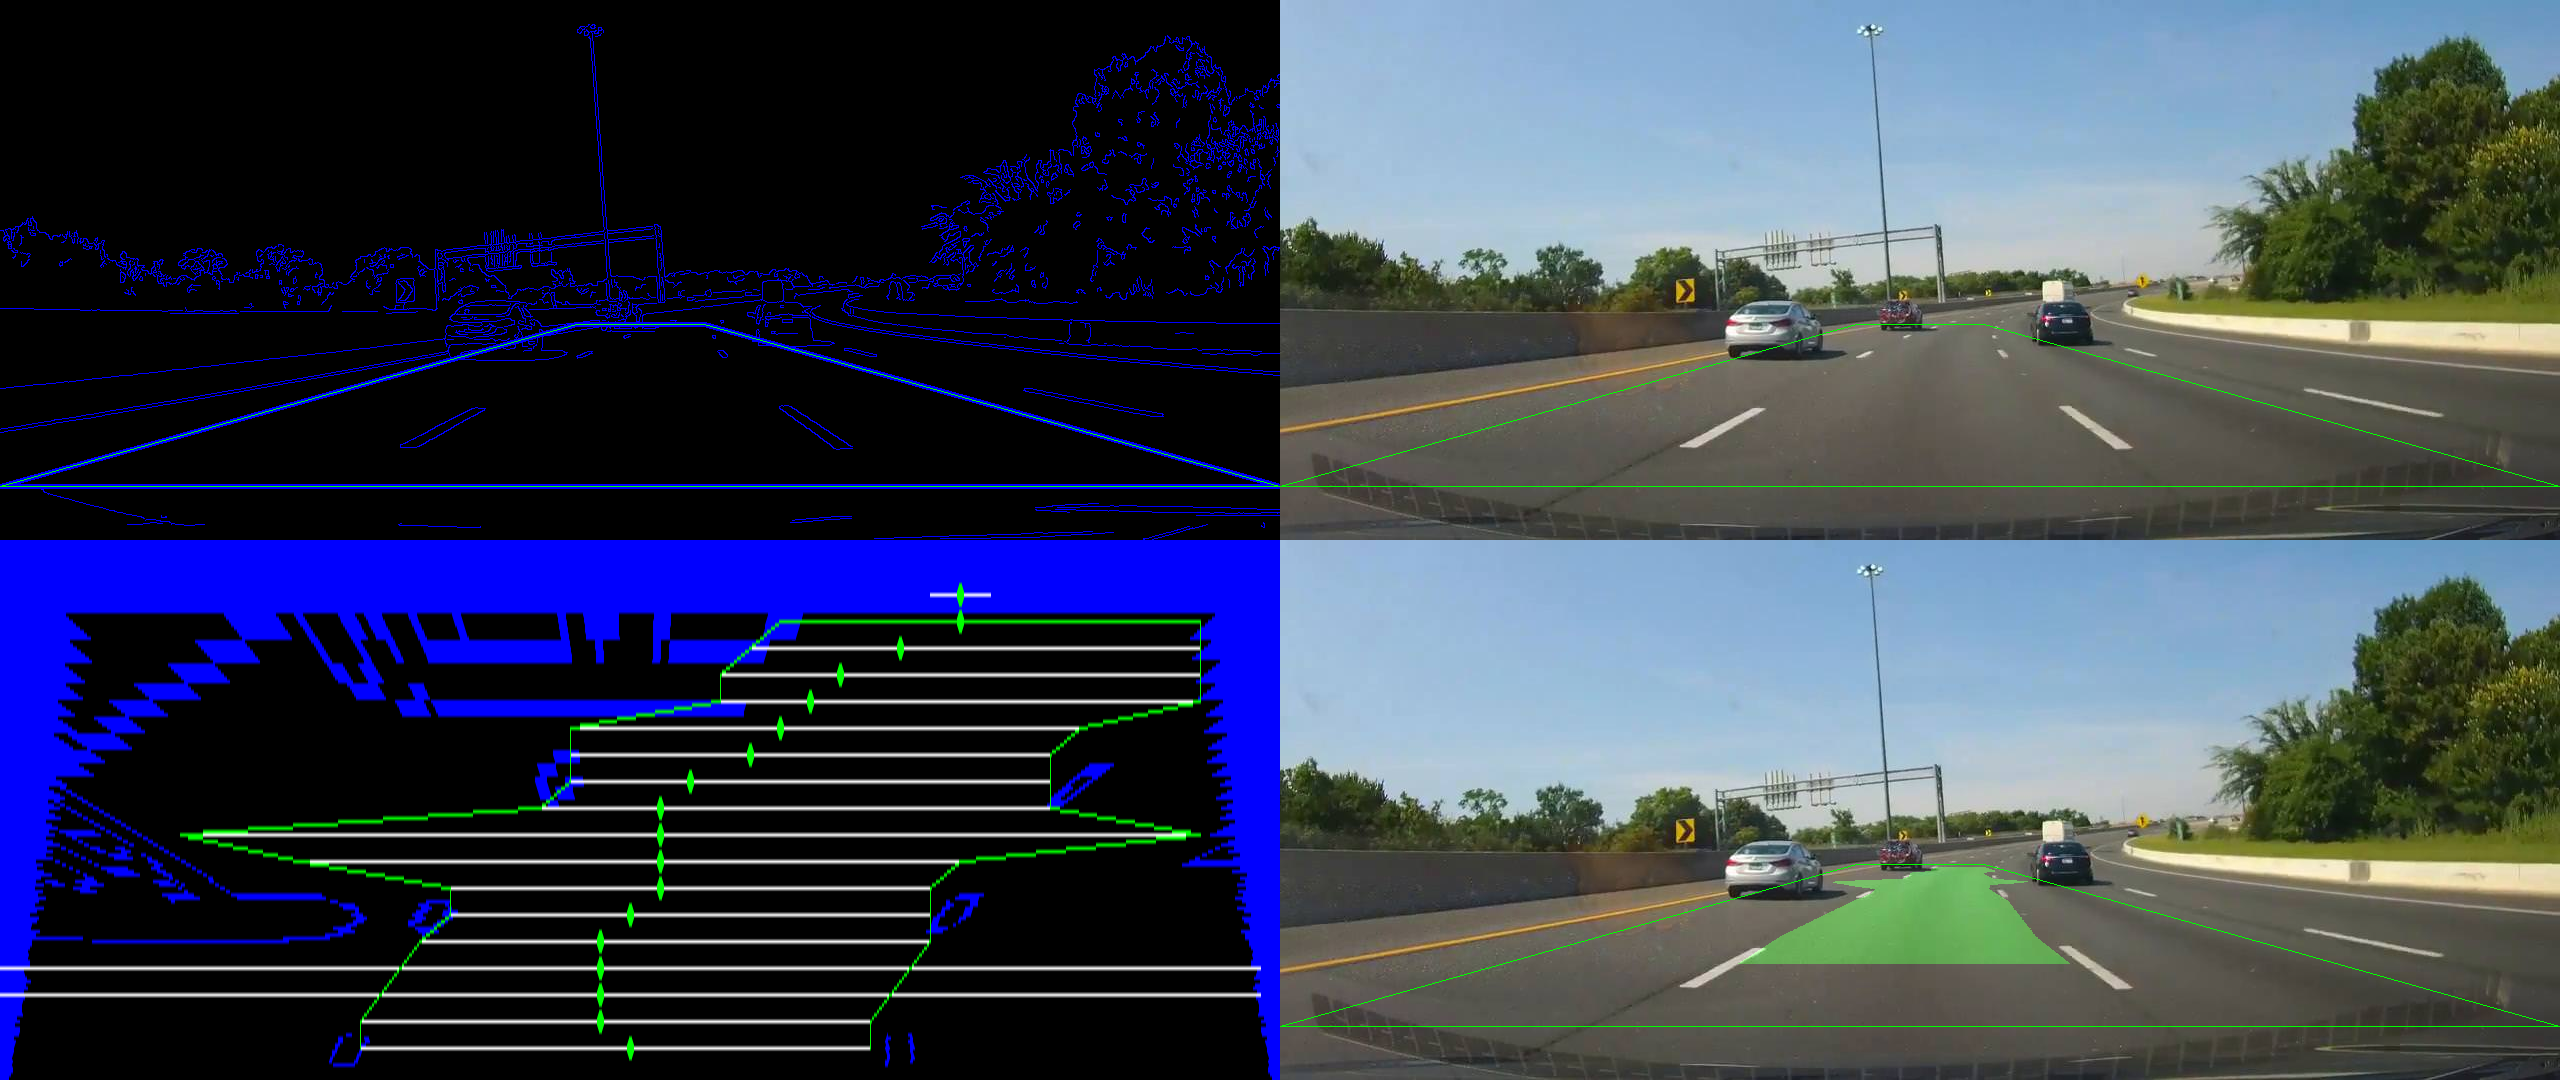

In [ ]:
vis1 = np.concatenate((cv2.resize(edges_img, (img.shape[1], img.shape[0])), cv2.resize(warp_edges_img, (img.shape[1], img.shape[0]))), axis=0)
vis2 = np.concatenate((img, result), axis=0)
vis3 = np.concatenate((vis1, vis2), axis=1)
cv2_imshow(vis3)